In [185]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## IMPORTS

In [186]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes

from hdbscan import all_points_membership_vectors, HDBSCAN
from umap import UMAP

from copy import deepcopy, copy

from upsetplot import from_memberships, plot, UpSet, from_indicators

from typing import Dict, List, Tuple, Optional

palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

# make a matplotlib cmap from limegreen to white
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("limegreen-white", 
                                         ["white", "limegreen"])



FONTSIZE = 24

In [187]:
# heatmap parms
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}
# from the data dictionary
site_fullname_dict = {
                  'LDN': "London",
                  'MTL': "Montreal",
                  'SAN': "San Diego",
                  'RIO': "Rio de Janeiro",
                  'LUS': "Lusaka",
}

# assign consistent styles
site_style_dict = {
              1: 'o',
              2: 'D',
              3: 'P',
              4: 'X',
              5: 's',
}

In [188]:
figdir    = "./OUTPUT/lc-pos-figures"
reportdir = "../lc2-report"
data_dir  = "../lc-project-data"

## FUNCTIONS

In [189]:
# TODO: move these to a module


In [190]:
#===============================================================================
def compare_two_clusters(df, a, b):
#===============================================================================
# a function to compare two clusters - returns the concatenated cluster data for further analysis

    subset_a = df.query(f"cluster == {a}")
    subset_b = df.query(f"cluster == {b}")

    index_a = subset_a.index
    index_b = subset_b.index

    df_a = df.loc[index_a]
    df_b = df.loc[index_b]

    # concatenate
    df_ab = pd.concat([df_a, df_b])

    # cast cluster to int
    df_ab["cluster"] = df_ab["cluster"].astype(int)

    return df_ab


In [191]:
#===============================================================================
def make_centroids(e, lbls):
#===============================================================================

    # assume that lbls is a pandas series
    if isinstance(lbls, pd.Series):
        lbls = lbls.values
    


    # get the centroids of the umap coordinates by cluster
    centroids = pd.DataFrame(e, 
                                columns = ["x", "y"]).assign(cluster = lbls).groupby("cluster").mean()
    return centroids


#===============================================================================
def make_plot_df(embeddings, clusterer, index, sites):
#===============================================================================

    d = pd.DataFrame(embeddings, columns = ["x", "y"], index = index)
    d["Cluster"]             = clusterer.labels_
    d["Cluster Confidence"]  = clusterer.probabilities_


    try:
        d["Most Likely Cluster"] = np.argmax(all_points_membership_vectors(clusterer), axis = 1)
    except (KeyError, AttributeError):
        d["Most Likely Cluster"] = clusterer.labels_


    # EXPT

    d["Site"]                = sites


    return d



In [192]:
#===============================================================================
def plot_clusters(
                    df: pd.DataFrame, 
                    site_name_dict: dict,
                    centroids: Optional[bool] = False, 
                    title: Optional[str] = None,
                      most_likely: bool = False,
                      size_by_prob: bool = False,
                      ax: Optional[Axes] = None,
                      FONTSIZE: int = 24,
                      style = "Site",
                      ):
#===============================================================================

    # plot the embeddings
    # fig, ax = plt.subplots(figsize=(10, 10))

    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig = None
        ax = ax
        pass


    if most_likely:
        hue = "Most Likely Cluster"
    else:
        hue = "Cluster"

    if size_by_prob:
        size = "Cluster Confidence"
    else:
        size = None

    sns.scatterplot(data = df, 
                    x = "x",
                    y = "y",
                    s = 150,
                    edgecolor = 'black', 
                    hue       = hue,
                    linewidth = 0.5, 
                    palette   = palette_dict,
                    style     = style,
                    style_order = site_name_dict.values(),
                    markers = ['o','D', 'P', 'X', 's'],
                    size      = size,
                    # size      = "Cluster Confidence",
                    ax = ax
                        )

    if centroids is not None:
        # plot centroids
        if centroids == True:
            centroids = make_centroids(df[["x", "y"]].values, df["Cluster"])
            plot_centroids(centroids, ax, palette_dict = None)

    # set title
    if title:
        plt.title(title)

    # place the legend outside to the right of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # turn off axis labels and ticks
    if ax == None:
        plt.xticks([]); plt.yticks([]);
        plt.xlabel(""); plt.ylabel("");

        # make labels larger
        plt.tick_params(axis='both', which='major', labelsize=16)

        # make the legend larger
        plt.setp(ax.get_legend().get_texts(), fontsize='24') # for legend text
        plt.setp(ax.get_legend().get_title(), fontsize='24') # for legend title

    # turn off x and y axis labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # turn off grid
    ax.grid(False)
    
    # axis labels
    ax.set_xlabel("Dimension 1", fontsize = FONTSIZE)
    ax.set_ylabel("Dimension 2", fontsize = FONTSIZE)


    # make the legend larger
    plt.setp(ax.get_legend().get_texts(), fontsize=FONTSIZE-2) # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=FONTSIZE-2) # for legend title


    # return fig, ax

#===============================================================================
def plot_centroids(centroids, 
                   ax, 
                   alpha = 1.0, 
                   palette_dict = None, 
                   fontsize = 24,
                   show_edge = False,
                   ):
#===============================================================================
    # plot the centroids



    for i, centroid in centroids.iterrows():

        # don't plot the -1 cluster
        if i != -1:

            # plot in colour, if passed in
            if palette_dict is not None:
                ec = palette_dict[i]
            else:
                ec = 'w'

            if show_edge:
                ec = 'black'

            ax.annotate(
                        i,
                        (centroid.x, centroid.y), 
                        ha='center',
                        va='center',
                        bbox=dict(boxstyle="round,pad=0.3", 
                                    fc="k", 
                                    # ec="#ababab",
                                    ec = ec,
                                    # ec="w",
                                    # fc="white", 
                                    # ec="black",
                                    lw=2, 
                                    alpha=alpha,
                                    ),
                        fontsize = fontsize,
                        color = 'white',
                        # make font bold
                        fontweight = "bold",
                        )



In [193]:
#===============================================================================
def make_upset_data(df, 
                    ftrs, 
                    method = "mean", 
                    add_column = None,
                    keep_features = False):
#===============================================================================

    if method not in ["mean", "median"]:
        print(f"Method {method} not supported.")

    else:
        if method == "mean":
            new_df = df[ftrs] > df[ftrs].mean(axis = 0)
        # elif method == "median":
        else:
            new_df = df[ftrs] > df[ftrs].median(axis = 0)

    new_df = new_df[ftrs]
    new_df.rename(columns= {c: f">{c}" for c in ftrs}, inplace = True)

    df2 = pd.concat([df, new_df, add_column], axis = 1) # type: ignore
    # if keep_features == True:
    #     pass
    # else:
    #     df2 = df2.set_index(list(new_df.columns))

    return df2

In [194]:
#===============================================================================
def excursion_plot(d, 
                    method = "mean",
                    grouper = "cluster",
                    style: str = "binary",
                    # figsize = (6,64),
                    ax = None,
                    cmap = cc.cm.bjy,
                    top_n = None,
                    ):
#===============================================================================

    # TODO: colour map to match the cluster thumbnails
    # TODO: drop age, sex

    norm = None

    # qq.astype(int)
    if ax == None:
        fig, ax = plt.subplots()
    else:
        ax = ax


    # find all object columns and drop them
    d = d.select_dtypes(exclude = "object")

    # set the figsize to scale with the number of features
    figsize = (6, d.shape[1] / 5)

    # get the global median for each feature
    global_median = d.median()
    global_mean   = d.mean()

    globals = pd.concat([global_median, global_mean], axis = 1)
    globals.columns = ["Ensemble Median", "Ensemble Mean"]

    globals.drop(grouper, inplace = True)


    # per feature mean and median
    mm_mean   = d.groupby(grouper).mean().T
    mm_median = d.groupby(grouper).median().T

    # which version?
    if method == "mean":
        mm = mm_mean
        selector = "Ensemble Mean"
    elif method == "median":
        mm = mm_median
        selector = "Ensemble Median"
    else:
        print(f"Method {method} not supported.")
        

    if top_n is not None:
        mm = mm[:top_n]

    if style == "cont":
        # do the basic plot of means or medians
        # colourmap
        # cmap = cc.cm.bjy
        # fig, ax = plt.subplots(figsize=figsize)

        # heatmsp
        sns.heatmap(mm, 
                        cmap = cmap, 
                        ax   = ax, 
                        **heatmap_parms, 
                        norm = norm, 
                        annot = True,
                        annot_kws = {"fontsize": 8}
                        )

        plt.title(f"Excursion Plot: Feature {str.title(method)} by Cluster")
        plt.yticks(fontsize = 8);
        qq = None

    else:
        # mm is the mean or median per cluster per feature
        qq = pd.DataFrame(index = mm.index, columns = mm.columns)

        # for each cluster c in mm, 
        for c in mm.columns:
            # for each feature in this cluster, compare to the respective global mean
            for i, v in enumerate(mm[c].values):
                # is this cluster's mean or median greater than 
                # the global ensemble mean or median?
                # this will fill qq with true/false
                qq.loc[qq.index[i],c] = v >  globals.loc[qq.index[i], selector] # type: ignore

        # # qq.astype(int)
        # fig, ax = plt.subplots(figsize=figsize)

        sns.heatmap(qq.astype(int), 
                    # cmap = cc.bjy, 
                    cmap = cmap,
                    ax = ax, 
                    cbar = False, 
                    vmin = 0, 
                    linewidth = 0.5, 
                    square = False, 
                    linecolor = 'k'
                    )

        plt.yticks(fontsize = 8);
        plt.title(f"Excursion Plot: {str.title(grouper)} {str.title(method)} > {selector}")

    return globals, qq

In [195]:
#===============================================================================
def plot_cluster_by_site(src,
                         data,
                         labels,
                        site_name_dict: dict,

                         title: str,
                         tag: str,
                         ):
#===============================================================================

    # make a copy of the source data
    site_g = src.copy()

    # augment with cluster labels
    site_g.loc[data.index, "cluster"] = labels["Cluster"]

    # group and count
    cluster_by_site = site_g.groupby("cluster")["SITE"].value_counts().unstack().T

    # fill missing values
    cluster_by_site = cluster_by_site.fillna(0).astype(int)

    # map SITE values using site-name_dict

    cluster_by_site.index = cluster_by_site.index.map(site_name_dict)



    # rename columns
    cluster_by_site.columns = cluster_by_site.columns.astype(int)
    # cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

    # sort index alphabetically
    

    fig, ax = plt.subplots(figsize=(8,8), layout = "constrained")

    sns.heatmap(cluster_by_site, 
                robust     = True, 
                ax         = ax, 
                annot      = True, 
                fmt        = "d", 
                cmap       = "viridis", 
                square     = True, 
                linewidths = 0.5, 
                linecolor  = "w", 
                cbar       = False)

    # rename axis labels
    plt.xlabel("Cluster")
    plt.ylabel("Site")
    plt.title(title)

    # fn = f"cluster-membership-umap-{tag}.png"
    # p = f"{figdir}/{fn}"

    # plt.savefig(p, dpi = 300, bbox_inches = 'tight')


In [347]:
#===============================================================================
def plot_multiple_features(
                            d: pd.DataFrame,
                            X: pd.DataFrame,
                            plot_df: pd.DataFrame,
                            feature_map: dict,
                            highlight_colour: str = "red",
                            ax = None,
                            subfig_label = None,
                            show_centroids = True,
            ):
#===============================================================================
    
    
    sympt_dict = {0:"Absent", 1:"Present"}

    max_feature_length = min(20, len(d))


    int_feat = d["Feature"][:max_feature_length]

    if ax is not None:
        pass
    else:
        fig, ax = plt.subplots(4, 5, 
                                figsize=(20, 20), 
                                sharex = True, 
                                sharey = True, 
                                layout = "constrained")

    ax  = ax.flatten()

    centroids = make_centroids(plot_df[["x", "y"]].values, plot_df["Cluster"])

# plot the features by cluster
    for i, f in enumerate(int_feat):
        the_ax = ax[i]


        if i == 0: 
            # add an annotation
            the_ax.annotate(subfig_label,
                        xy=(0, 1.01), 
                        xycoords='axes fraction',
                        xytext=(0.0,0.0), 
                        textcoords = 'offset points',
                        fontsize = FONTSIZE*2,
                        horizontalalignment='center', 
                        verticalalignment='bottom',
                        fontweight = "bold",

                        )



        if f == "age":
            plot_df[f] = X[f]
            the_palette = 'magma'
            hue_order = None

        elif f == "sex":
            plot_df[f] = X[f].map({0: "Male", 1:"Female"})
            the_palette = ["#ababab", "#5577aa"]
            hue_order = ["Male", "Female"]

        else:
            plot_df[f] = X[f].map(sympt_dict)
            the_palette = ['white', highlight_colour]
            hue_order = ["Absent", "Present"]


        sns.scatterplot(data = plot_df, 
                    x         = "x", 
                    y         = "y", 
                    hue       = f,
                    hue_order = hue_order,
                    palette   = the_palette, 
                    style     = "Site", 
                    style_order = site_name_dict.values(), 
                    markers   = list(site_style_dict.values()),
                    edgecolor = 'k', 
                    linewidth = 0.125, 
                    s         = 20, 
                    # alpha     = 0.75,
                    ax        = the_ax
                    )

        if show_centroids:
            # add centroids for reference
            plot_centroids(centroids, the_ax, alpha = 0.35, show_edge = True)

        # turn off the ticks on the ax
        the_ax.set_xticks([]); the_ax.set_yticks([])
        the_ax.set_xlabel(""); the_ax.set_ylabel("")

        # set axis title
        the_ax.set_title(feature_map[f], fontsize = FONTSIZE - 2)

        # turn off the legnd on the ax
        the_ax.legend().remove()

    # set aspect ratio to 1
    # the_ax.set_aspect('equal')

    # plt.show()

    # return fig, ax


In [197]:
#===============================================================================
def plot_feature_importances(
                            features20: pd.DataFrame,
                            feature_map: dict,
                            feature_colour_map: dict,
                            ax,
                            FONTSIZE: int = 24,
                            ):
#===============================================================================
    
    # second, plot the feature importances in the "bars" window
    sns.barplot(
                    y       = features20["Feature"], 
                    x       = features20["Importance"],
                    palette = feature_colour_map,
                    hue     = features20["Feature"],
                    # orient = "h",
                    ax = ax,
                    legend = None,
                    )

    # make the x ticks and label larger
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    ax.set_xlabel(""); ax.set_ylabel("")

    # no legend
    # ax.get_legend().remove()

    # turn off legend




## LOAD DATA

In [302]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

today = "2024-05-05"

# load the dataset from disk
ds_all = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')
ds     = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')

In [303]:
df_all = ds_all.data.to_pandas()
df     = ds.data.to_pandas()

In [304]:
# drop __index_level_0__
df = df.drop(columns = ["__index_level_0__"])

In [344]:
# import good feature names
feature_map_df = pd.read_csv(f"./JSON/niceFeatures.csv")

# construct a dict with feature as key and clean as value
feature_map = {row["feature"]: row["clean"] for i, row in feature_map_df.iterrows()}

# load the colourmap dict
import json

with open("./JSON/selectFeaturePalette_NiceFeat.json", "r") as f:
    feature_colour_map = json.load(f)

print(f"{len(feature_map)} features loaded.")
print(f"{len(feature_colour_map)} colours loaded.")

88 features loaded.
77 colours loaded.


In [345]:
cc.glasbey_hv[:len(feature_map)+1]

[[0.188235, 0.635294, 0.854902],
 [0.988235, 0.309804, 0.188235],
 [0.898039, 0.682353, 0.219608],
 [0.427451, 0.564706, 0.309804],
 [0.545098, 0.545098, 0.545098],
 [0.090196, 0.745098, 0.811765],
 [0.580392, 0.403922, 0.741176],
 [0.839216, 0.152941, 0.156863],
 [0.121569, 0.466667, 0.705882],
 [0.890196, 0.466667, 0.760784],
 [0.54902, 0.337255, 0.294118],
 [0.737255, 0.741176, 0.133333],
 [0.227451, 0.003922, 0.513725],
 [0.0, 0.262745, 0.0],
 [0.058824, 1.0, 0.662745],
 [0.368627, 0.0, 0.25098],
 [0.776471, 0.741176, 1.0],
 [0.258824, 0.313725, 0.321569],
 [0.721569, 0.0, 0.501961],
 [1.0, 0.717647, 0.701961],
 [0.490196, 0.007843, 0.0],
 [0.380392, 0.14902, 1.0],
 [1.0, 1.0, 0.603922],
 [0.682353, 0.788235, 0.670588],
 [0.0, 0.52549, 0.486275],
 [0.333333, 0.227451, 0.0],
 [0.580392, 0.988235, 1.0],
 [0.0, 0.74902, 0.0],
 [0.490196, 0.0, 0.627451],
 [0.670588, 0.447059, 0.0],
 [0.568627, 1.0, 0.0],
 [0.003922, 0.745098, 0.541176],
 [0.0, 0.270588, 0.482353],
 [0.784314, 0.509804,

## LC+, LC-, HC

### Select which sets of features to use

In [204]:
tag = 'all'

print(df.shape) # type: ignore

(5664, 448)


In [205]:
# get the RIO and LUS data, and drop any object columns
df_rio = df.query("SITE == 4").select_dtypes(exclude = "object")
df_lus = df.query("SITE == 5").select_dtypes(exclude = "object")
df_mtl = df.query("SITE == 2").select_dtypes(exclude = "object")
df_san = df.query("SITE == 3").select_dtypes(exclude = "object")
df_ldn = df.query("SITE == 1").select_dtypes(exclude = "object")

df_rio = df_rio.drop(columns = ["SITE", "sex", "age"])
df_lus = df_lus.drop(columns = ["SITE", "sex", "age"])
df_mtl = df_mtl.drop(columns = ["SITE", "sex", "age"])
df_san = df_san.drop(columns = ["SITE", "sex", "age"])
df_ldn = df_ldn.drop(columns = ["SITE", "sex", "age"])
                                

# how many na values?
print(df_rio.isna().sum().sum())
print(df_lus.isna().sum().sum())

# drop rows with missing values
df_rio = df_rio.dropna()
df_lus = df_lus.dropna()
df_mtl = df_mtl.dropna()
df_san = df_san.dropna()
df_ldn = df_ldn.dropna()


# cast any booleans to int
df_rio = df_rio.astype(int)
df_lus = df_lus.astype(int)
df_mtl = df_mtl.astype(int)
df_san = df_san.astype(int)
df_ldn = df_ldn.astype(int)


# df_lus has some values > 1; replace them with 1
df_lus = df_lus.clip(upper = 1)
df_mtl = df_mtl.clip(upper = 1)



0
0


In [206]:
# fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(df_rio.T, ax = ax, cmap = "viridis", cbar = False,)


In [207]:
# fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(df_lus.T, ax = ax, cmap = "viridis", cbar = False,)


In [208]:
# fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(df_mtl.T, ax = ax, cmap = "viridis", cbar = False,)


In [209]:
LC_pos = df.query('LC_STATUS == "LC_POS"').copy() # type: ignore
LC_neg = df.query('LC_STATUS == "LC_NEG"').copy() # type: ignore 
HC     = df.query('LC_STATUS == "HC"').copy()     # type: ignore

In [210]:
# LC_pos["CD-severity_level___3"]
# # make a heatmap of all of the CD-severity levels
# fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(LC_pos[["CD-severity_level___0", "CD-severity_level___1", "CD-severity_level___2", "CD-severity_level___3"]],)
# # severity level is accoerding to PCR
# # what about sites that didn't use PCR? are they all zero by default?
# LC_pos["CD-mode_of_diag"].value_counts()
# sns.heatmap(LC_pos[["CD-mode_of_diag"]])

In [211]:
LC_pos.shape, LC_neg.shape, HC.shape

((2194, 448), (3367, 448), (103, 448))

In [212]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass
LC_pos

sex   age  SITE  MED-Analgesics  MED-Anesthetics  MED-Antibacterials  \
0     2.0  30.0     2               0                0                   0   
1     1.0  33.0     2               0                0                   0   
2     2.0  36.0     2               0                0                   0   
3     2.0  50.0     2               0                0                   0   
4     1.0  40.0     2               0                0                   0   
...   ...   ...   ...             ...              ...                 ...   
5659  1.0  48.0     3               0                0                   0   
5660  2.0  42.0     3               0                0                   0   
5661  1.0  23.0     3               0                0                   0   
5662  1.0  71.0     3               0                0                   0   
5663  2.0  58.0     3               0                0                   0   

      MED-Anticonvulsants  MED-Antidepressants  MED-Antifungals  \
0                       0                    0                0   
1                       0                    0                0   
2                       0                    0                0   
3                       0                    0                0   
4                       0                    0                0   
...                   ...                  ...              ...   
5659                    0                    0                0   
5660                    0                    0                0   
5661                    0                    0                0   
5662                    0                    0                0   
5663                    0                    0                0   

      MED-Antimigraine-agents  ...  LABS-IND-troponinihigh  \
0                           0  ...                     0.0   
1                           0  ...                     0.0   
2                           0  ...                     0.0   
3                           0  ...                     0.0   
4                           0  ...                     0.0   
...                       ...  ...                     ...   
5659                        0  ...                     0.0   
5660                        0  ...                     0.0   
5661                        0  ...                     0.0   
5662                        0  ...                     0.0   
5663                        0  ...                     0.0   

      LABS-IND-troponint  LABS-IND-troponinthigh  LABS-IND-urea  LABS-IND-wbc  \
0                    0.0                     0.0            0.0           0.0   
1                    0.0                     0.0            0.0           0.0   
2                    0.0                     0.0            0.0           0.0   
3                    0.0                     0.0            0.0           0.0   
4                    0.0                     0.0            0.0           0.0   
...                  ...                     ...            ...           ...   
5659                 0.0                     0.0            1.0           0.0   
5660                 0.0                     0.0            1.0           1.0   
5661                 0.0                     0.0            0.0           0.0   
5662                 0.0                     0.0            1.0           0.0   
5663                 0.0                     0.0            1.0           1.0   

      SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5  
0         0.0      0.0      0.0      0.0      0.0  
1         0.0      0.0      0.0      0.0      0.0  
2         0.0      0.0      0.0      0.0      0.0  
3         1.0      0.0      0.0      0.0      0.0  
4         0.0      0.0      0.0      0.0      0.0  
...       ...      ...      ...      ...      ...  
5659      0.0      0.0      1.0      0.0      0.0  
5660      0.0      0.0      0.0      0.0      0.0  
5661      0.0      0.0      1.0      1.0      0.0  
5662      0.0      0.0    

In [213]:
# make a list of the columns
ftrs = list(df.columns)

# how many features start with one of ["SYMP", "CD", "MED"]?

for sw in ["SYMP", "CD", "MED", "VAX", "HHX", "IMG","LAB", "SUBS"]:
    print(sw, len([f for f in ftrs if f.startswith(sw)]))



SYMP 56
CD 244
MED 28
VAX 1
HHX 54
IMG 9
LAB 47
SUBS 5


## SITES

In [214]:
LC_pos['SITE'].value_counts(), LC_neg['SITE'].value_counts(), HC['SITE'].value_counts()

(SITE
 2    895
 4    651
 5    272
 3    266
 1    110
 Name: count, dtype: int64,
 SITE
 2    1997
 5     994
 1     177
 4     128
 3      71
 Name: count, dtype: int64,
 SITE
 5    38
 1    32
 2    21
 4     9
 3     3
 Name: count, dtype: int64)

# CLUSTERING

In [215]:
# clustering
from sklearn.preprocessing import MinMaxScaler

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [216]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos.copy()

# drop certain columns, to experiment with effect on clustering

# drop columns that relate to non-covid events
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___4').columns)
# the foregoing drops medication_received___3 and medication_received___4
# we need to restore them
LC_pos_["CD-medication_received___3"] = df["CD-medication_received___3"]
LC_pos_["CD-medication_received___4"] = df["CD-medication_received___4"]
LC_pos_["CD-ventilatory_support_type___3"] = df["CD-ventilatory_support_type___3"]
LC_pos_["CD-ventilatory_support_type___4"] = df["CD-ventilatory_support_type___4"]

LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-4').columns)

# drop specific columns
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-severity_level').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-mode_of').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-type_of').columns)

# drop medications and substances
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED-').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SUBST-').columns)

# find all column names that start with SYMPT and end with ___1
# these are for the initial covid infection
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT.*___1').columns)

# drop all HHX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'HHX').columns)

# drop all VAX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'VAX').columns)

# drop all CD-covid_test_result
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-covid_test_result').columns)

# drop all LABS-IND*
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS-IND').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'IMG').columns)

# drop all CD-
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-').columns)

vitals = ['temperature',
'heart_rate',
'bp_systolic',
'bp_diastolic',
'respiratory_rate',
'o2_saturation',]

# remove any features that contain words inthe vitals list
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '|'.join(vitals)).columns)


print(LC_pos_.shape)
# for c in LC_pos_.columns:
#     print(c)
# sort the feature names alphabetically
LC_pos_ = LC_pos_.sort_index(axis = 1)
print(LC_pos_.shape)

(2194, 246)
(2194, 246)


In [217]:
LC_pos_.columns

Index(['CD-acute_kidney_injury___1', 'CD-acute_kidney_injury___2',
       'CD-acute_respiratory_distress___1',
       'CD-acute_respiratory_distress___2', 'CD-adjunctive___1',
       'CD-anemia___1', 'CD-anemia___2', 'CD-anxiety___1', 'CD-anxiety___2',
       'CD-asthma___1',
       ...
       'SYMPT-seizure___2', 'SYMPT-shortness_of_breath_dyspne___2',
       'SYMPT-skin_rash___2', 'SYMPT-sore_throat___2',
       'SYMPT-trouble_speaking_aphasia_d___2', 'SYMPT-weight_loss___2',
       'SYMPT-wheezing_or_stridor___2', 'VAX-vaccinated', 'age', 'sex'],
      dtype='object', length=246)

In [218]:
# get a list of all features that start with CD- and end with ___1
# these are the initial covid symptoms
new_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___1")]

# get a list of all features that start with CD- and end with ___2
# these are the follow-up covid symptoms
worse_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___2")]

new_and_worse = new_symptoms + worse_symptoms

In [219]:
new_symptoms, worse_symptoms, new_and_worse

(['CD-acute_kidney_injury___1',
  'CD-acute_respiratory_distress___1',
  'CD-adjunctive___1',
  'CD-anemia___1',
  'CD-anxiety___1',
  'CD-asthma___1',
  'CD-bacterial_viral_or_cryptog___1',
  'CD-bacteriemia___1',
  'CD-brain_fog___1',
  'CD-bronchiolitis___1',
  'CD-cardiac_arrest___1',
  'CD-copd___1',
  'CD-decompensated_heart_failur___1',
  'CD-deep_vein_thrombosis_dvt___1',
  'CD-depression___1',
  'CD-difficulty_with_concentrat___1',
  'CD-disseminated_intravascular___1',
  'CD-encephalitis___1',
  'CD-endocarditis___1',
  'CD-gastrointestinal_haemorrha___1',
  'CD-hyperglycemia___1',
  'CD-hypoglycemia___1',
  'CD-insomnia___1',
  'CD-interstitial_lung_disease___1',
  'CD-left_ventricular_function___1',
  'CD-liver_dysfunction___1',
  'CD-medication_received___1',
  'CD-memory_problems___1',
  'CD-meningitis___1',
  'CD-mood_change___1',
  'CD-myocardial_infarction_stem___1',
  'CD-myocarditis___1',
  'CD-myositis___1',
  'CD-new_atrial_fibrillation_or___1',
  'CD-non_st_elevat

In [220]:
# drop the dag and SITE columns - these might guide the clustering algorithm to cluster by site

try:
    LC_pos_ = LC_pos_.drop(columns=['LC_STATUS'])
except:
    pass

# always drop the SITE!
X = scaler.fit_transform(LC_pos_.drop(columns=['SITE']))     # type: ignore


# sort X randomly
# X = X.sample(frac = 1)

## Use UMAP to visualize the data and cluster

In [221]:
from hdbscan import HDBSCAN, approximate_predict, all_points_membership_vectors
from umap import UMAP

### Handling missing values

In [222]:
# the clustering algorithms depend on the data being complete
# drop rows that have a nan in any column
X.dropna(inplace = True, axis = 0)

print(X.shape)

(2189, 245)


In [223]:
# X_worse = X[worse_symptoms].copy()
# X_new   = X[new_symptoms].copy()

# X = X[new_and_worse].copy()
# X = X[worse_symptoms].copy()
# X = X[new_symptoms].copy()

### EMBED and CLUSTER

/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(random_state=42, verbose=True)
Mon May 20 15:53:19 2024 Construct fuzzy simplicial set
Mon May 20 15:53:21 2024 Finding Nearest Neighbors
Mon May 20 15:53:21 2024 Finished Nearest Neighbor Search
Mon May 20 15:53:21 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon May 20 15:53:23 2024 Finished embedding


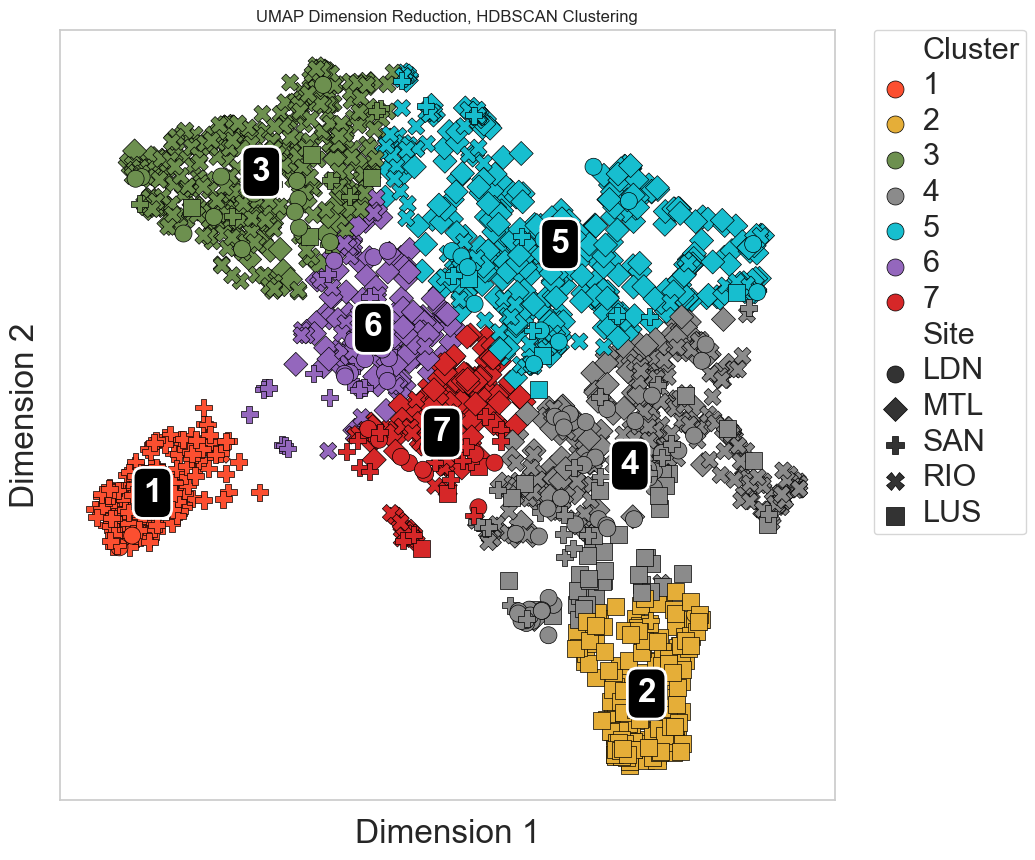

In [224]:
# sklearn pipelines
import sklearn.cluster as cluster
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

from hdbscan import HDBSCAN

min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                'spread':       1.0,
                'random_state': 42,
            }

umap_transformer = UMAP(**umap_parms, verbose = True)

embedding_model = umap_transformer

# instantiate the pipeline
pipe = Pipeline([
                # scale to unit size
                ('scaler', MinMaxScaler()),
                # for embeddings, we can use TSNE or UMAP
                ('embed', embedding_model),
                # the sklearn HDBCSAN implementation does not have all the 
                # methods of the hdbscan package, so we need to use the hdbscan package
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# if isinstance(pipe.steps[1][1], UMAP):
#     points   = pipe["embed"].embedding_
# elif isinstance(pipe.steps[1][1], FunctionTransformer):
#     points   = pipe["embed"].transform(X)
# else:
#     print(f"Something went wrong - {pipe.steps[1][1]}")


points   = pipe["embed"].embedding_
clusters = pipe["cluster"].labels_
probs    = pipe["cluster"].probabilities_
sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # cluster labels are the maximally probable cluster
cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
                           axis = 1)

clusters = cluster_labels


plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
plot_df["Cluster"]            = [c+1 for c in clusters]
plot_df["Cluster Confidence"] = probs
plot_df["Site"]               = sites

# what fraction of the data is in each cluster?
plot_df["Cluster"].value_counts(normalize = True)*100

plot_clusters(plot_df, site_name_dict, title = f"UMAP Dimension Reduction, HDBSCAN Clustering", centroids = True, size_by_prob = False, ax = None)

# # plt.savefig(f"{figdir}/tsne-hdbscan-umap.png", dpi = 300, bbox_inches = 'tight')

In [225]:
# 2024-05-06
# redundant: recoded the erroneous records (21 MTL patients) to patient_type 99 to remove from the LC_pos and LC_neg datasets

# # find the indices of the points that x < 4
# idx = plot_df.query("x < 4").index
# idx

# # # read the records from "LC_POSITIVE_RECORD_IDS.csv"

# record_ids = pd.read_csv(f"{data_dir}/LC_POSITIVE_RECORD_IDS.csv", header = 0, index_col = 0)

# # # record_ids

# # # get the patient record_id that corresponds to idx
# record_ids.loc[idx]["record_id"].to_list()
# # # sns.heatmap(X.loc[idx].filter(regex = 'SYMPT').T, **heatmap_parms
# # # sns.heatmap(X.sample(20).filter(regex = 'SYMPT').T, **heatmap_parms)

#### Cluster by Site

In [226]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

# convert to percent of site
# cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

print(cluster_by_site)

# output cluster_by_site to latex
# cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")
# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster      1      2      3      4      5      6      7
Site                                                    
LDN        2.0    1.0   14.0   53.0   12.0   17.0   11.0
LUS        0.0  213.0    4.0   44.0    4.0    0.0    3.0
MTL        0.0    0.0   75.0  164.0  399.0  130.0  127.0
RIO        1.0    0.0  335.0  182.0   79.0   26.0   27.0
SAN      191.0    1.0    8.0   22.0    9.0   16.0   19.0


#### RFC Model to identify features that differentiate clusters

In [227]:
# use a random forest classifier to find the most important features
from sklearn.ensemble import RandomForestClassifier

# use all cores
clf = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )



# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy

boruta = BorutaPy(clf, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )
boruta.fit(X, cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100


BorutaPy finished running.

Iteration: 	33 / 100
Confirmed: 	37
Tentative: 	0
Rejected: 	208


BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=124,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x3963C7540),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x3963C7540,
         verbose=1)

In [228]:
# make a subset of the data with the important features and 
# fit a classifiera on it, using the cluster labels as the target
important_features = X.columns[boruta.support_]
clf.fit(X[important_features], cluster_labels)

RandomForestClassifier(max_depth=7, n_estimators=124, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x3963C7540)

In [229]:
# # make a table of features and their importances from the classifier
# fi_df = pd.DataFrame(clf.feature_importances_, index = clf.feature_names_in_, columns = ["Importance"])

# # make a table of all of the features and their rankings
# fff = pd.DataFrame({
#                         # "Feature": features, 
#                         "Feature": X.columns, 
#                         "Ranking": boruta.ranking_, 
#                         "Importance":boruta.support_, })


# # fill fff with the feature importances
# # start with zero
# fff["FI"] = 0.0

# # now fill in the numeric values for the important features
# for i, f in fff.iterrows():
#     if f["Importance"] == True:
#         # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
#         fff.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# # sort by FI
# fff.sort_values(by = "FI", ascending = False, inplace = True)

In [230]:
# make a dataframe of the important features
dd = pd.DataFrame(clf.feature_importances_, 
                  index = important_features, 
                  columns = ["Importance"]).sort_values("Importance", ascending = False)

dd.reset_index(inplace = True)
dd.rename(columns = {"index": "Feature"}, inplace = True)

# select only the top20 features
features20 = dd[:20].copy()

# rename the features
features20["Feature"] = features20["Feature"].map(feature_map)

# normalize the importances
features20["Importance"] = features20["Importance"] / features20["Importance"].max()

# assign a colour
features20["Colour"] = features20["Feature"].map(feature_colour_map)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


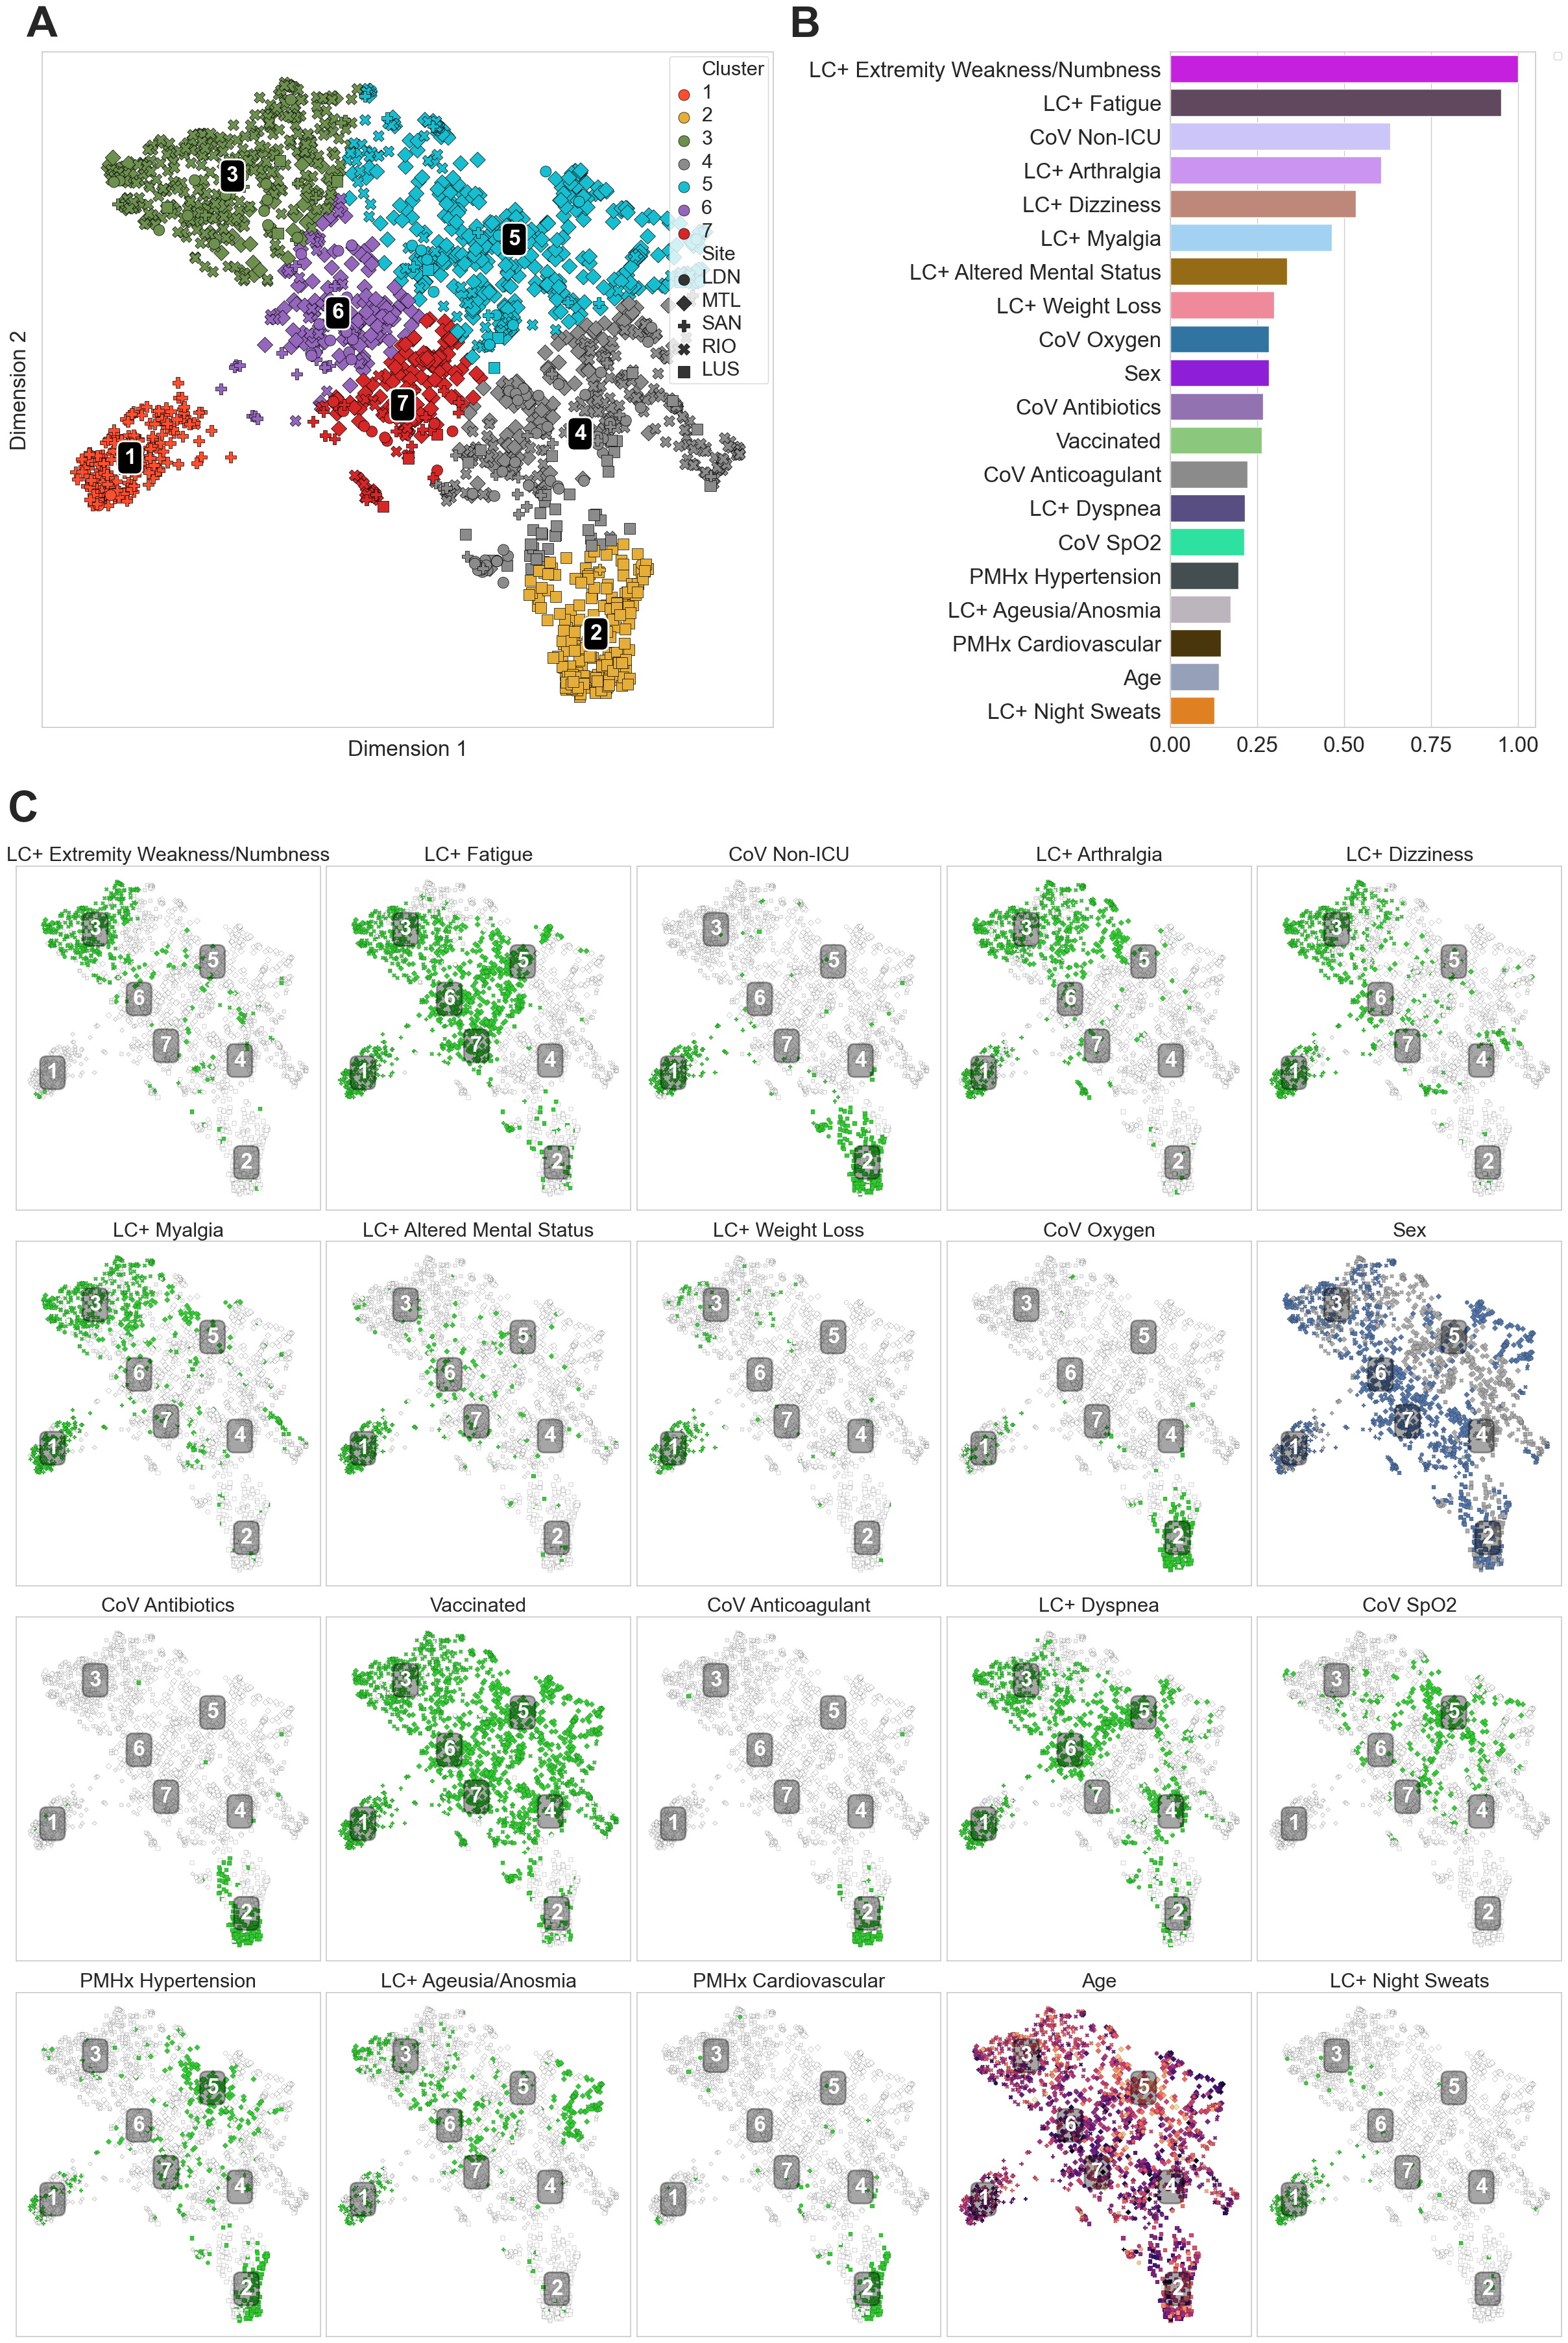

In [231]:
fig     = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[2,4], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, site_name_dict, title = None, centroids = True, size_by_prob = False, ax = axs0[0])
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# plot_clusters(plot_df, site_name_dict, title = None, centroids = True, size_by_prob = False, ax = axs0[1])

plot_feature_importances(features20, feature_map, feature_colour_map, axs0[1], FONTSIZE)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
axs1 = subfigs[1].subplots(4,5)

plot_multiple_features(dd, 
                        X,
                        plot_df, 
                        feature_map, 
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = False

if SAVE:
    plt.savefig(f"{figdir}/feature-importances.png", dpi = 600, bbox_inches = 'tight')
    plt.savefig(f"{figdir}/feature-importances.jpg", dpi = 600, bbox_inches = 'tight')
    plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

### Excursion Plots

In [232]:
# make a table of features and their importances from the classifier
fi_df = pd.DataFrame(clf.feature_importances_, 
                     index = clf.feature_names_in_, 
                     columns = ["Importance"])

# make a table of all of the features and their rankings
fff = pd.DataFrame({
                        "Feature": X.columns, 
                        "Ranking": boruta.ranking_, 
                        "Importance":boruta.support_, })


# fill fff with the feature importances
# start with zero
fff["FI"] = 0.0

# now fill in the numeric values for the important features
for i, f in fff.iterrows():
    if f["Importance"] == True:
        # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
        fff.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# sort by FI
fff.sort_values(by = "FI", ascending = False, inplace = True)

In [233]:
fff

Feature  Ranking  Importance        FI
221  SYMPT-extremity_weakness_or_numb___2        1        True  0.117226
222                     SYMPT-fatigue___2        1        True  0.111590
119                   CD-type_of_care___2        1        True  0.074148
226       SYMPT-joint_pain_arthralgia___2        1        True  0.071082
219                   SYMPT-dizziness___2        1        True  0.062531
..                                    ...      ...         ...       ...
87        CD-other_cardiac_arrhythmia___2      176       False  0.000000
88                             CD-outcome       99       False  0.000000
89                              CD-oxygen       72       False  0.000000
90                    CD-pancreatitis___1      176       False  0.000000
122       CD-ventilatory_support_type___3      176       False  0.000000

[245 rows x 4 columns]

In [234]:
# save the cluster labels to a copy of the original dataframe
A = X.copy()
M = X.copy()

# sosrt columns in the order set in fff
M = M[fff["Feature"]]

# augment with cluster labels
A["cluster"] = [c+1 for c in cluster_labels]
M["cluster"] = [c+1 for c in cluster_labels]


In [235]:
cluster_by_site

Cluster      1      2      3      4      5      6      7
Site                                                    
LDN        2.0    1.0   14.0   53.0   12.0   17.0   11.0
LUS        0.0  213.0    4.0   44.0    4.0    0.0    3.0
MTL        0.0    0.0   75.0  164.0  399.0  130.0  127.0
RIO        1.0    0.0  335.0  182.0   79.0   26.0   27.0
SAN      191.0    1.0    8.0   22.0    9.0   16.0   19.0

In [236]:
cbsm = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cbsm.index.name = "cluster"

# map the site_fullname_dict to the index
cbsm.columns = cbsm.columns.map(site_fullname_dict)
cbsm = cbsm.T
cbsm

cluster                 1          2          3          4          5  \
Site                                                                    
London           1.818182   0.909091  12.727273  48.181818  10.909091   
Lusaka           0.000000  79.477612   1.492537  16.417910   1.492537   
Montreal         0.000000   0.000000   8.379888  18.324022  44.581006   
Rio de Janeiro   0.153846   0.000000  51.538462  28.000000  12.153846   
San Diego       71.804511   0.375940   3.007519   8.270677   3.383459   

cluster                 6          7  
Site                                  
London          15.454545  10.000000  
Lusaka           0.000000   1.119403  
Montreal        14.525140  14.189944  
Rio de Janeiro   4.000000   4.153846  
San Diego        6.015038   7.142857

In [237]:
zzz = M.groupby("cluster").mean()

# get the first 20 columns
zzz = zzz[fff["Feature"][:20]]

# rename the columns
for c in zzz.columns:
    zzz.rename(columns = {c: feature_map[c]}, inplace = True)

# drop age and sex
zzz = zzz.drop(columns = ["Age", "Sex"])

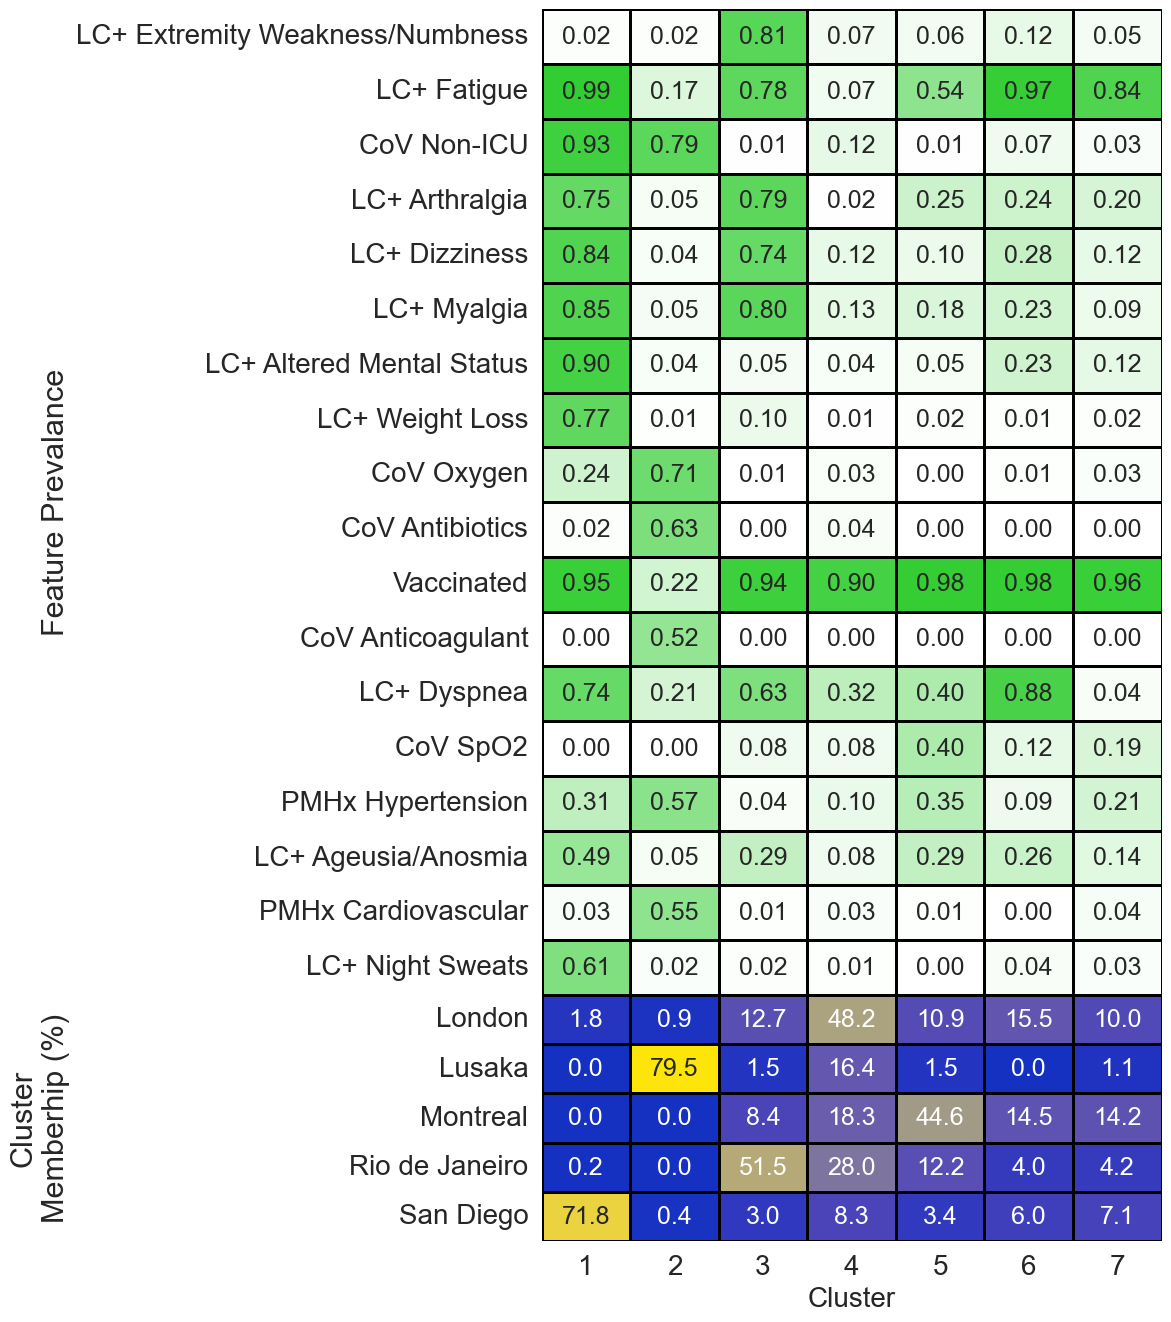

In [238]:


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(8,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

sns.heatmap(zzz.T, 
            cmap = cmap, 
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 18}
)

# turn off the xticks and x label
axs0.set_xticks([]); axs0.set_xlabel("")

sns.heatmap(cbsm,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 18}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure
plt.savefig(f"{figdir}/feature-prevalence-by-cluster.png", dpi = 600, bbox_inches = 'tight')


### UPSET PLOTS

In [239]:
# A["SITE"] = LC_pos_["SITE"]
# II = pd.DataFrame(scaler.inverse_transform(A.drop(["cluster", "SITE"], axis = 1))) # type: ignore

# # get column names and index names from X 
# II.columns = X.columns
# II.index   = X.index


# # A.shape, X.shape, II.shape
# # vv = A.drop("cluster", axis = 1)
# B = II.copy()

# # augment with site labels
# B["SITE"] = LC_pos_["SITE"].map(site_name_dict)

# interesting = list(fff["Feature"][:5])
# upset_A = make_upset_data(A, 
#                        interesting, 
#                        )

# upset_data = make_upset_data(B, 
#                                 interesting, 
#                                 keep_features = True
#                                 )

# indicators_bool = upset_data.select_dtypes(include = ['bool'])
# us = UpSet(
#     from_indicators(indicators_bool, data = upset_data),
#     min_subset_size=15,
#     # max_subset_size=200,
#     show_counts                = True,
#     sort_categories_by         = "-input",
#     subset_size                = "count",
#     intersection_plot_elements = 0,
#     orientation                = "horizontal",
# )

# # us.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = cc.glasbey_light[0],  linewidth = 3, )

# us.add_stacked_bars(by="SITE", 
#                        title="Count SITE", 
#                        elements=10, 
#                        colors = cc.m_glasbey_hv, 
#                        )

# us.plot()
# plt.show()

In [240]:
# upset = UpSet(upset_A, 
#                 subset_size = "count", 
#                 orientation = "horizontal", 
#                 sort_categories_by         = "-input",
#                 show_counts = False, 
#                 intersection_plot_elements = 0,
#                 max_subset_size = 200
#                 )
# # upset.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = "red", linewidth = 3)
# # upset.style_categories(">HHX-HIV or AIDS", shading_facecolor = "blue")

# # upset.add_stacked_bars(by="cluster", title="Count Cluster", elements=5, colors = cc.m_glasbey_hv)


# upset.plot()
# plt.show()

In [241]:
# from scipy.stats import chi2_contingency

# rd = {}

# for site1 in site_name_dict.values():

#     for site2 in site_name_dict.values():

#         for col in X.columns:

#             # get the index of rows where SITE is site1 or site2
#             idx = LC_pos_["SITE"].isin([site1, site2])

#             print(idx)

#             ct = pd.crosstab(LC_pos_.loc[idx]["SITE"], X.loc[idx][col]).rename(index = site_name_dict)


#             print(ct)

#             result = chi2_contingency(ct)
#             if result[1] < 0.05:
#                 # print(ct)
#                 print(f"{site}: \t{col} --> p = {result[1]}")
#                 rd.update({site: result[1]})


# # for col in X.columns:


# #     ct = pd.crosstab(LC_pos_["SITE"], X[col]).rename(index = site_name_dict)

# #     result = chi2_contingency(ct)
# #     if result[1] < 0.05:
# #         # print(ct)
# #         # print(f"{col}: p = {result[1]}")
# #         rd.update({col: result[1]})

# # # make dataframe from rd
# # rd_df = pd.DataFrame.from_dict(rd, orient = "index", columns = ["p-value"])

# # # sort by p-value
# # rd_df.sort_values(by = "p-value", inplace = True, ascending = False)
# # rd_df

# Examine each site to identify subclusters

In [242]:
LC_COLUMNS = LC_pos_.columns

# remove SITE from LC_COLUMNS
LC_COLUMNS = LC_COLUMNS.drop(["SITE", "age"])


from sklearn.pipeline import Pipeline
from hdbscan import HDBSCAN

In [180]:
result_dict = {}

for i, (k,v) in enumerate(site_name_dict.items()):
    print(i, k, v)

    # LC_pos_ = df.query(f"SITE == {k}").copy()
    the_data = LC_pos_.query(f"SITE == {k}").copy()

    # drop age
    the_data = the_data.drop(columns = ["age"])


    X = scaler.fit_transform(the_data)     # type: ignore
    X = X.dropna(axis = 0)
    X = X[LC_COLUMNS]

    print(f"Data shape = {the_data.shape}")
    print(f"X shape    = {X.shape}")


    # reduce and cluster
    # sklearn pipelines
    # from sklearn.preprocessing import FunctionTransformer


    min_cluster_size = int(np.sqrt(X.shape[0]))

    hdb_parms = {
                    # min_cluster_size is roughly 
                    # sqrt(n) where n is the number of samples
                    'min_cluster_size': min_cluster_size, 
                    'min_samples': min_cluster_size,
                    'cluster_selection_method': 'leaf', # more granular
                    'cluster_selection_epsilon': 0.1,
                }

    umap_parms = {
                    'n_components': 2,
                    'spread':       1.0,
                    'random_state': 42,
                    'verbose':      False
                }

    umap_transformer = UMAP(**umap_parms)
    embedding_model = umap_transformer
    # instantiate the pipeline
    pipe = Pipeline([
                    # scale to unit size
                    ('scaler', MinMaxScaler()),
                    # for embeddings, we can use TSNE or UMAP
                    ('embed', embedding_model),
                    # the sklearn HDBCSAN implementation does not have all the 
                    # methods of the hdbscan package, so we need to use the hdbscan package
                    ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                    ])

    # apply to the feature dataframe
    pipe.fit(X)

    points   = pipe["embed"].embedding_
    clusters = pipe["cluster"].labels_
    probs    = pipe["cluster"].probabilities_
    # sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

    # # cluster labels are the maximally probable cluster
    cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
                            axis = 1)

    clusters = cluster_labels

    plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
    plot_df["Cluster"]            = [c+1 for c in clusters]
    plot_df["Cluster Confidence"] = probs
    # plot_df["Site"]               = sites

    # what fraction of the data is in each cluster?
    print(plot_df["Cluster"].value_counts(normalize = True)*100)

    # use a random forest classifier to find the most important features
    from sklearn.ensemble import RandomForestClassifier

    # use all cores
    clf = RandomForestClassifier(n_jobs=-1, 
                                #  n_estimators = 100, 
                                #  class_weight='balanced', 
                                max_depth=7
                                )

    # instantiate the Boruta feature selector
    from boruta_py.boruta import BorutaPy

    boruta = BorutaPy(clf, 
                    #   n_estimators = 1_000, 
                    n_estimators = 'auto',
                    verbose      = 0, 
                    random_state = 42, 
                    perc         = 100
                    )
    boruta.fit(X, cluster_labels)

    # make a subset of the data with the important features and 
    # fit a classifiera on it, using the cluster labels as the target
    important_features = X.columns[boruta.support_]
    clf.fit(X[important_features], cluster_labels)

    # print(important_features, clf.feature_importances_)

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()

    # # sosrt columns in the order set in fff
    M = M[important_features]

    # # augment with cluster labels
    M["cluster"] = [c+1 for c in cluster_labels]

    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()



    case_dict = {'plot_df': plot_df, 
                 'important_features': important_features,
                'mfv': mfv,
                 'classifier': clf, 
                 'boruta': boruta, 
                 'X': X,
                 'cluster_labels': cluster_labels,}

    result_dict.update({v: case_dict})

# plt.show()

0 1 LDN
Data shape = (110, 245)
X shape    = (110, 244)


/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Cluster
2    43.636364
3    34.545455
1    21.818182
Name: proportion, dtype: float64
1 2 MTL
Data shape = (895, 245)
X shape    = (895, 244)


/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Cluster
5    23.240223
2    22.458101
6    21.564246
4    12.849162
3    10.167598
1     9.720670
Name: proportion, dtype: float64
2 3 SAN
Data shape = (266, 245)
X shape    = (266, 244)


/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Cluster
3    42.857143
1    40.225564
2    16.917293
Name: proportion, dtype: float64
3 4 RIO
Data shape = (651, 245)
X shape    = (650, 244)


/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Cluster
4    20.615385
6    19.846154
2    19.692308
1    16.461538
3    12.307692
5    11.076923
Name: proportion, dtype: float64
4 5 LUS
Data shape = (272, 245)
X shape    = (272, 244)


/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Cluster
1    40.808824
2    22.794118
3    20.220588
4    16.176471
Name: proportion, dtype: float64


In [181]:
# TODO: move these to a module


def make_fi_df(classifier, important_features):
    # make a table of features and their importances from the classifier
    fi_df = pd.DataFrame(classifier.feature_importances_, 
                        index = important_features, 
                        columns = ["Importance"])
    
    # sort by importance
    fi_df = fi_df.sort_values("Importance", ascending = False)

    fi_df.reset_index(inplace = True)
    fi_df.rename(columns = {"index": "Feature"}, inplace = True)

    return fi_df

def make_top10(fi_df, feature_map, feature_colour_map):

    # select only the top20 features
    features20 = fi_df[:10].copy()

    # old names
    features20["OLD Feature"] = features20["Feature"]

    # rename the features
    features20["Feature"] = features20["Feature"].map(feature_map)

    # normalize the importances
    features20["Importance"] = features20["Importance"] / features20["Importance"].max()

    # assign a colour
    features20["Colour"] = features20["Feature"].map(feature_colour_map)


    return features20

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


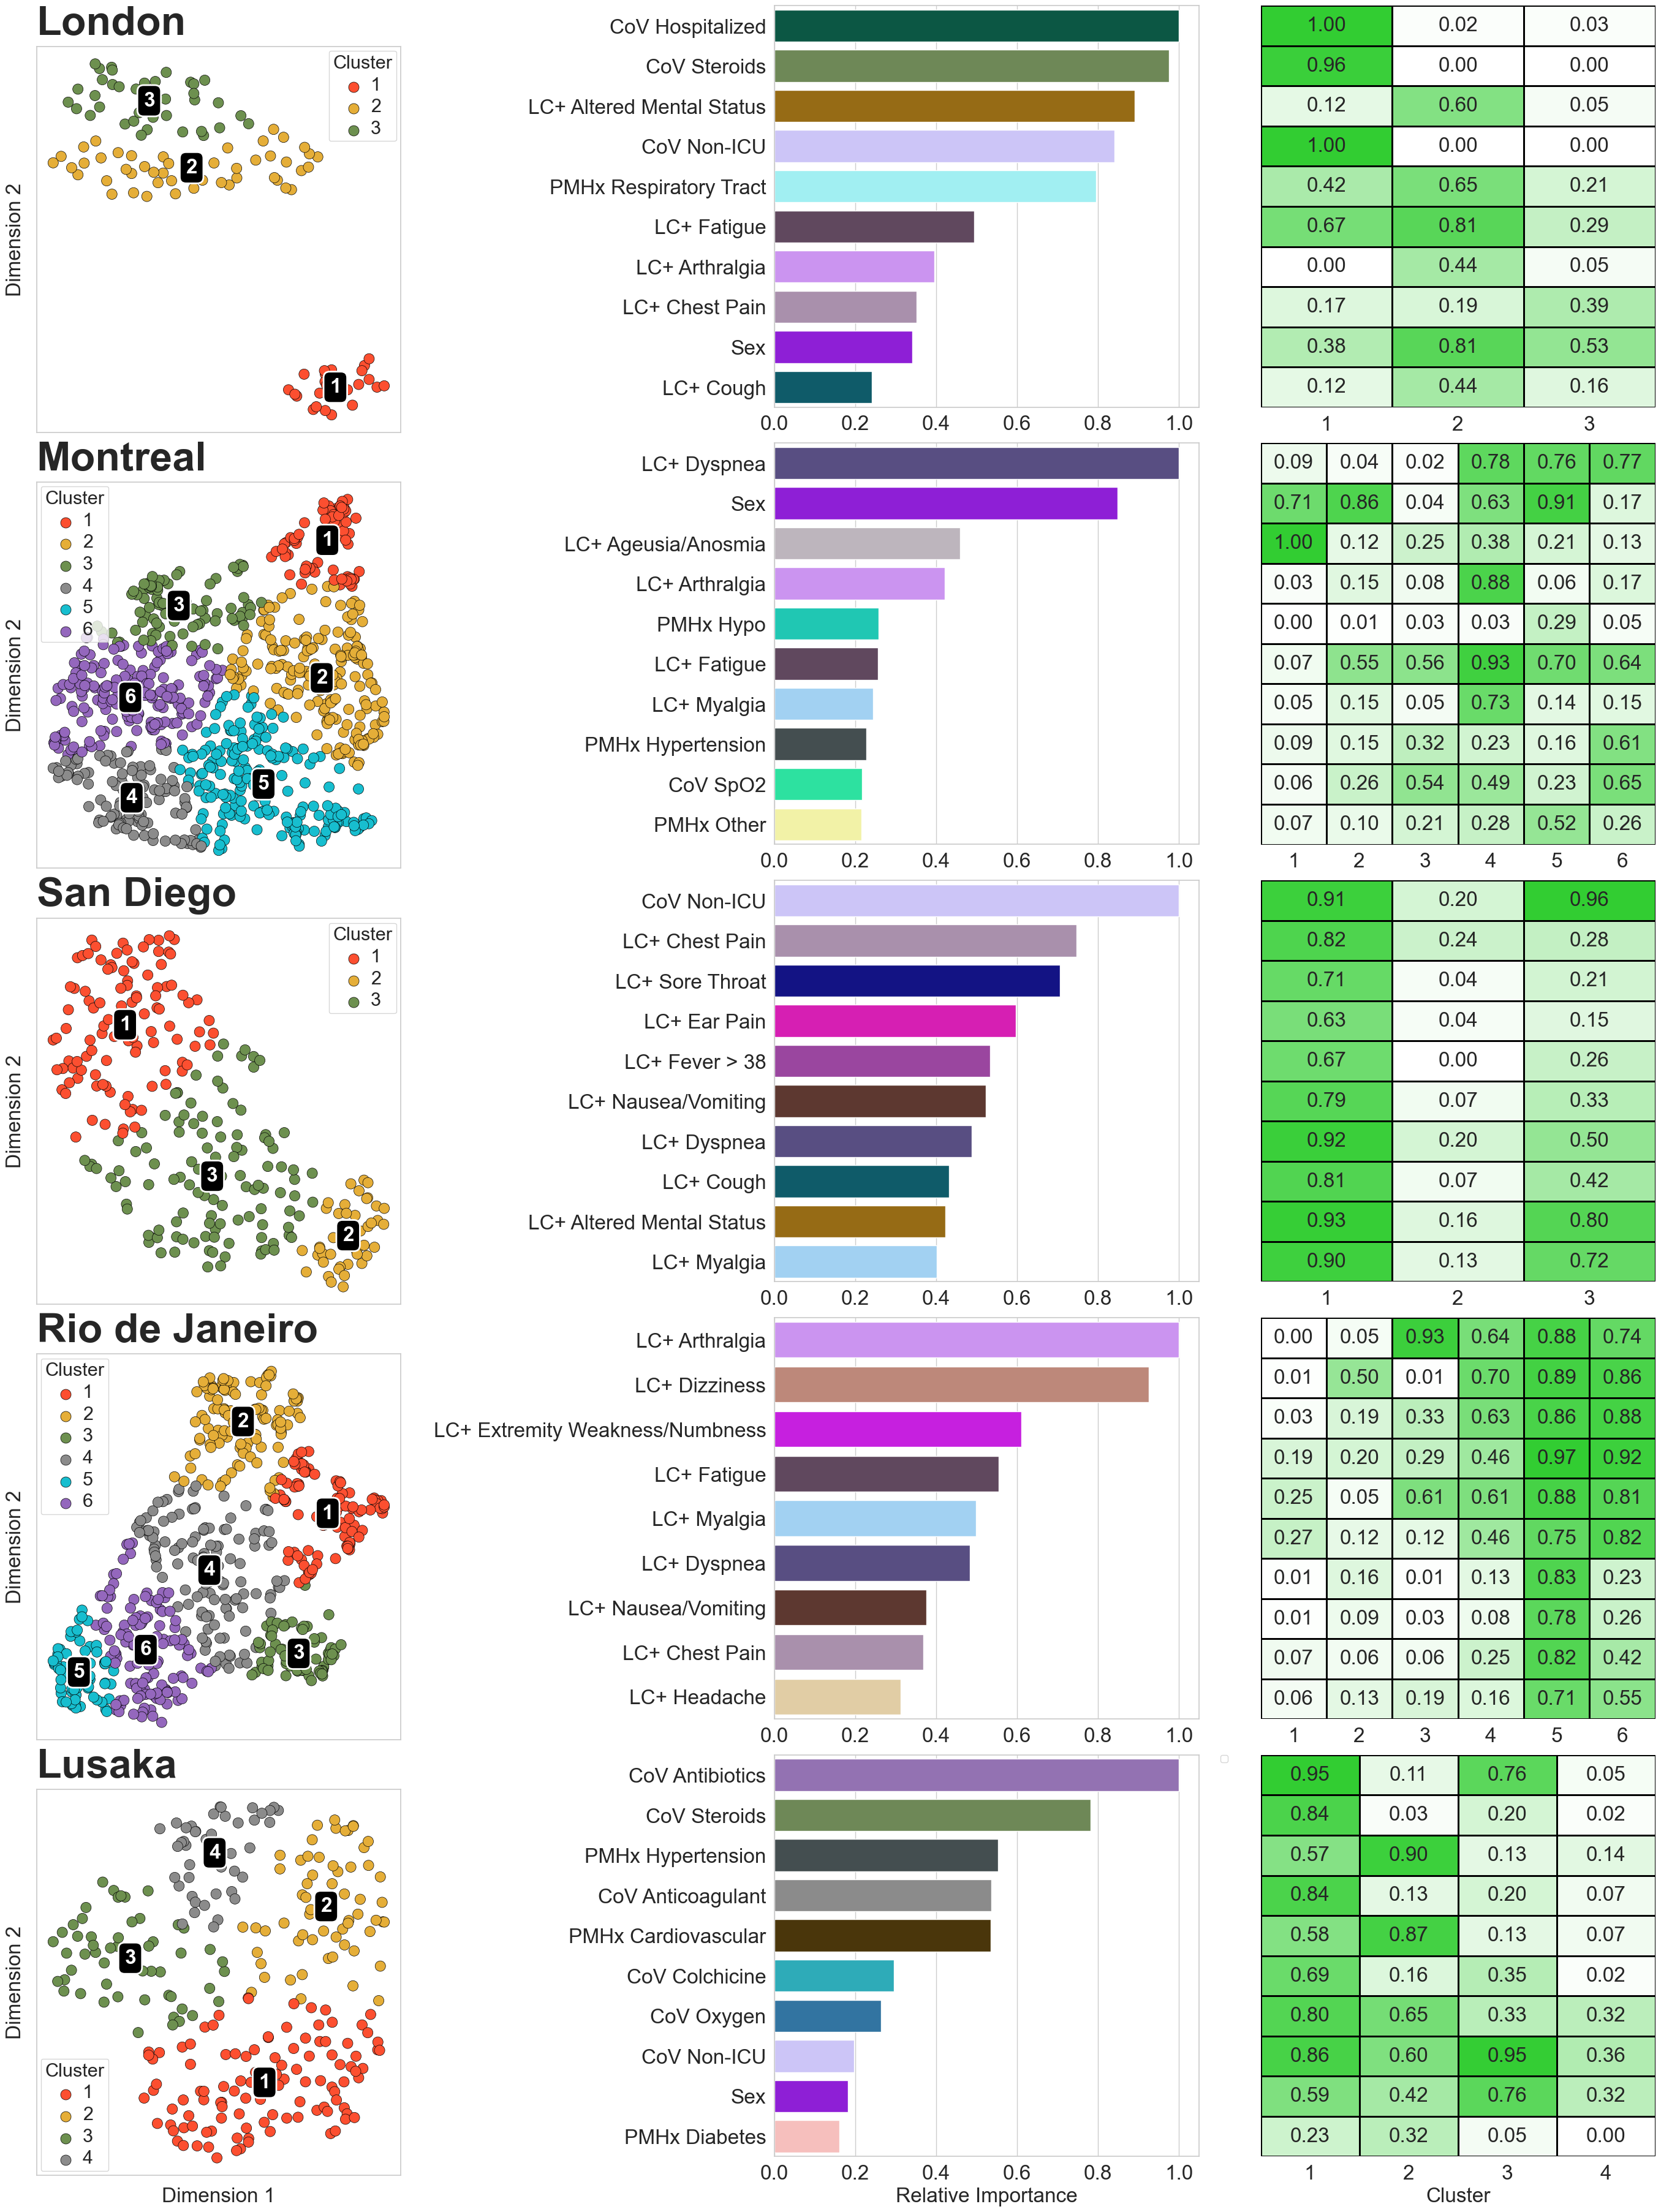

In [182]:
fig     = plt.figure(layout="constrained", figsize=(27,36), )
subfigs = fig.subfigures(1,3, wspace=0.05, hspace = 0.1, width_ratios=[1,2,1])

# fig.subplots_adjust(hspace = 0.0, wspace = 0.0)

axl = subfigs[0].subplots(5, 1)
axr = subfigs[2].subplots(5, 1, sharex = False)
axc = subfigs[1].subplots(5, 1)

for i,item in enumerate(result_dict.items()):

    k, v = item

    plot_df            = v['plot_df']
    important_features = v['important_features']
    X = v['X']
    # zzz = v['mean_feature_values']

    # clusters
    plot_clusters(plot_df, 
                  site_name_dict, 
                  title = None, 
                  centroids = True, 
                  size_by_prob = False, 
                  ax = axl[i], 
                  style = None
                  )
    # turn off the x label
    axl[i].set_xlabel("", fontsize = FONTSIZE)

    # feature importances
    fi_df = make_fi_df(v['classifier'], v['important_features'])
    # select only the top10 features
    features10 = make_top10(fi_df, feature_map, feature_colour_map)

    plot_feature_importances(features10, 
                             feature_map, 
                             feature_colour_map, 
                             axc[i], 
                             FONTSIZE)


    # the mean feature values
    mfv = X[important_features].mean()

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()
    M = M[important_features]
    # # augment with cluster labels
    M["cluster"] = [c+1 for c in v['cluster_labels']]
    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()


    # sort the mfv columns by the order of the important features
    mfv = mfv[features10["OLD Feature"]]

    # print(features10["Feature"], features10["OLD Feature"])

    # print(mfv)

    # map the feature names to the new names
    mfv.columns = features10["Feature"]

    # heatmaps
    sns.heatmap(mfv.T,
                cmap = cmap, 
                # ax = ax, 
                cbar = False, 
                vmin = 0, 
                linewidth = 1, 
                # linewidth = 0.5, 
                square = False, 
                linecolor = 'k',
                annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 24},
                ax = axr[i]
    )

    # turn off the y axis label
    axr[i].set_ylabel("", fontsize = FONTSIZE)

    # turn off y ticks
    axr[i].set_yticks([])

    #make tick labels larger
    axr[i].tick_params(axis='both', which='major', labelsize=FONTSIZE)
    axr[i].set_xlabel("", fontsize = FONTSIZE)


    axl[i].annotate(f"{site_fullname_dict[k]}",
                        xy=(0.0, 1.01), 
                        xycoords='axes fraction',
                        xytext=(0.0,0.0), 
                        textcoords = 'offset points',
                        fontsize = FONTSIZE*2,
                        horizontalalignment='left', 
                        verticalalignment='bottom',
                        fontweight = "bold",
                        )



axl[4].set_xlabel("Dimension 1", fontsize = FONTSIZE)
axr[4].set_xlabel("Cluster", fontsize = FONTSIZE)
axc[4].set_xlabel("Relative Importance", fontsize = FONTSIZE)

plt.savefig(f"{figdir}/subphenotype-feature-importances-by-site.png", dpi = 300, bbox_inches = 'tight')


# By SYMPTOM Status
- new, worsening, etc

In [416]:
# select only the features in new_and_worse
X = LC_pos_[new_and_worse].copy()
X.shape

(2194, 95)

In [417]:
# # find the indices in LC_pos_ that have anything but 2 in SITE
# idx = LC_pos_.query("SITE != 2").index
# idx

In [418]:
# select only the rows in idx
# X = X.loc[idx]
# X.shape

/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(random_state=42, verbose=True)
Mon May 20 22:27:37 2024 Construct fuzzy simplicial set
Mon May 20 22:27:39 2024 Finding Nearest Neighbors
Mon May 20 22:27:39 2024 Finished Nearest Neighbor Search
Mon May 20 22:27:39 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon May 20 22:27:51 2024 Finished embedding


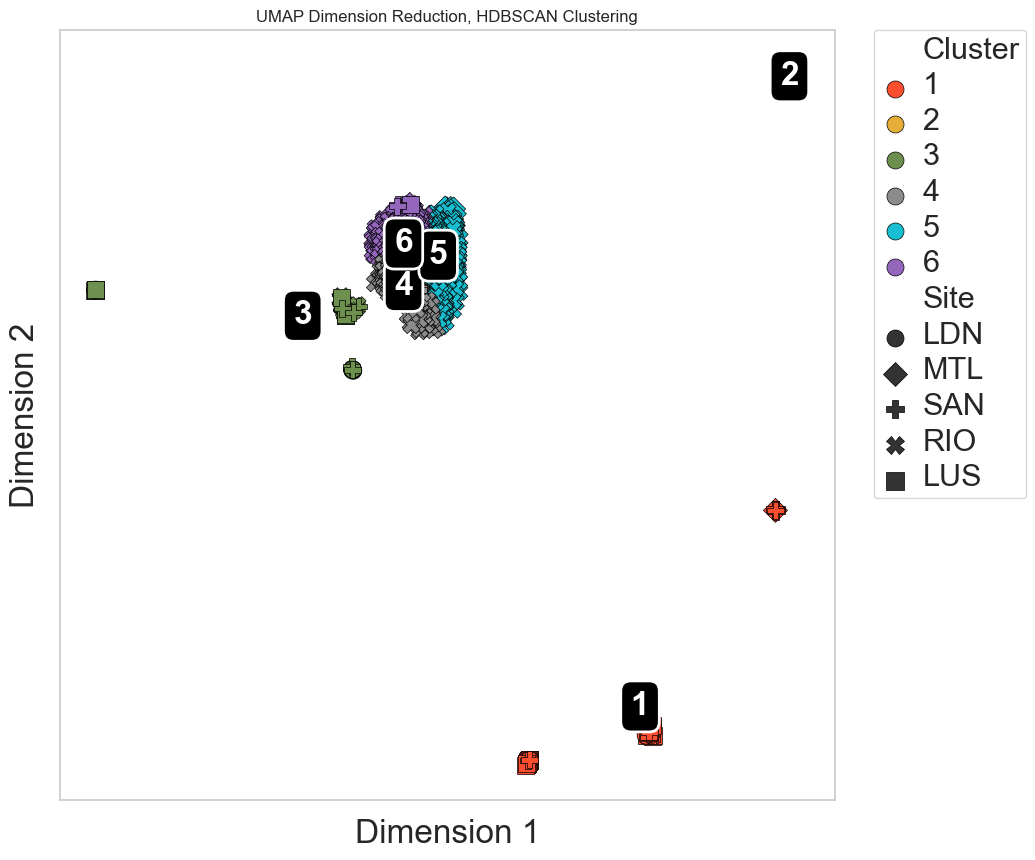

In [419]:
# sklearn pipelines
import sklearn.cluster as cluster
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

from hdbscan import HDBSCAN

min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples': min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                # 'spread':       5.0,
                'random_state': 42,
                # 'min_dist': 0.1,
                # 'metric': 'cosine',
            }

umap_transformer = UMAP(**umap_parms, verbose = True)

embedding_model = umap_transformer

# instantiate the pipeline
pipe = Pipeline([
                # scale to unit size
                ('scaler', MinMaxScaler()),
                # for embeddings, we can use TSNE or UMAP
                ('embed', embedding_model),
                # the sklearn HDBCSAN implementation does not have all the 
                # methods of the hdbscan package, so we need to use the hdbscan package
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# if isinstance(pipe.steps[1][1], UMAP):
#     points   = pipe["embed"].embedding_
# elif isinstance(pipe.steps[1][1], FunctionTransformer):
#     points   = pipe["embed"].transform(X)
# else:
#     print(f"Something went wrong - {pipe.steps[1][1]}")


points   = pipe["embed"].embedding_
clusters = pipe["cluster"].labels_
probs    = pipe["cluster"].probabilities_
sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # cluster labels are the maximally probable cluster
cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
                           axis = 1)

clusters = cluster_labels


plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
plot_df["Cluster"]            = [c+1 for c in clusters]
plot_df["Cluster Confidence"] = probs
plot_df["Site"]               = sites

# what fraction of the data is in each cluster?
plot_df["Cluster"].value_counts(normalize = True)*100

plot_clusters(plot_df, site_name_dict, title = f"UMAP Dimension Reduction, HDBSCAN Clustering", centroids = True, size_by_prob = False, ax = None)

# # plt.savefig(f"{figdir}/tsne-hdbscan-umap.png", dpi = 300, bbox_inches = 'tight')

In [420]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

# divid by the row sum
cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

# show only 2 decimal places
cluster_by_site = cluster_by_site.round(2)

print(cluster_by_site)

# output cluster_by_site to latex
# cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")
# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster      1      2      3      4      5      6
Site                                             
LDN      19.09   0.91  20.00  60.00   0.00   0.00
LUS      38.97  39.34   6.62  13.60   0.74   0.74
MTL       0.11   0.34   0.00   0.67  62.23  36.65
RIO       0.00   0.00   8.60  23.66  30.41  37.33
SAN      12.03  71.43   1.88  13.91   0.00   0.75


In [421]:


# use all cores
clf2 = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )


# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy

boruta = BorutaPy(clf2, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )
boruta.fit(X, cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=67,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x43F2BE240),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x43F2BE240,
         verbose=1)

In [422]:
# make a subset of the data with the important features and 
# fit a classifiera on it, using the cluster labels as the target
important_features = X.columns[boruta.support_]
clf2.fit(X[important_features], cluster_labels)

RandomForestClassifier(max_depth=7, n_estimators=67, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x43F2BE240)

In [423]:
fi_df = make_fi_df(clf2, important_features)
# select only the top10 features
features10 = make_top10(fi_df, feature_map, feature_colour_map)

In [424]:
fi_df

Feature  Importance
0                CD-type_of_care___2    0.483058
1         CD-medication_received___1    0.210010
2                CD-type_of_care___1    0.108912
3         CD-medication_received___2    0.047525
4             CD-memory_problems___1    0.042291
5                     CD-anxiety___1    0.039754
6                    CD-insomnia___1    0.032213
7                   CD-brain_fog___1    0.025872
8  CD-difficulty_with_concentrat___1    0.006292
9                  CD-depression___1    0.004073

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


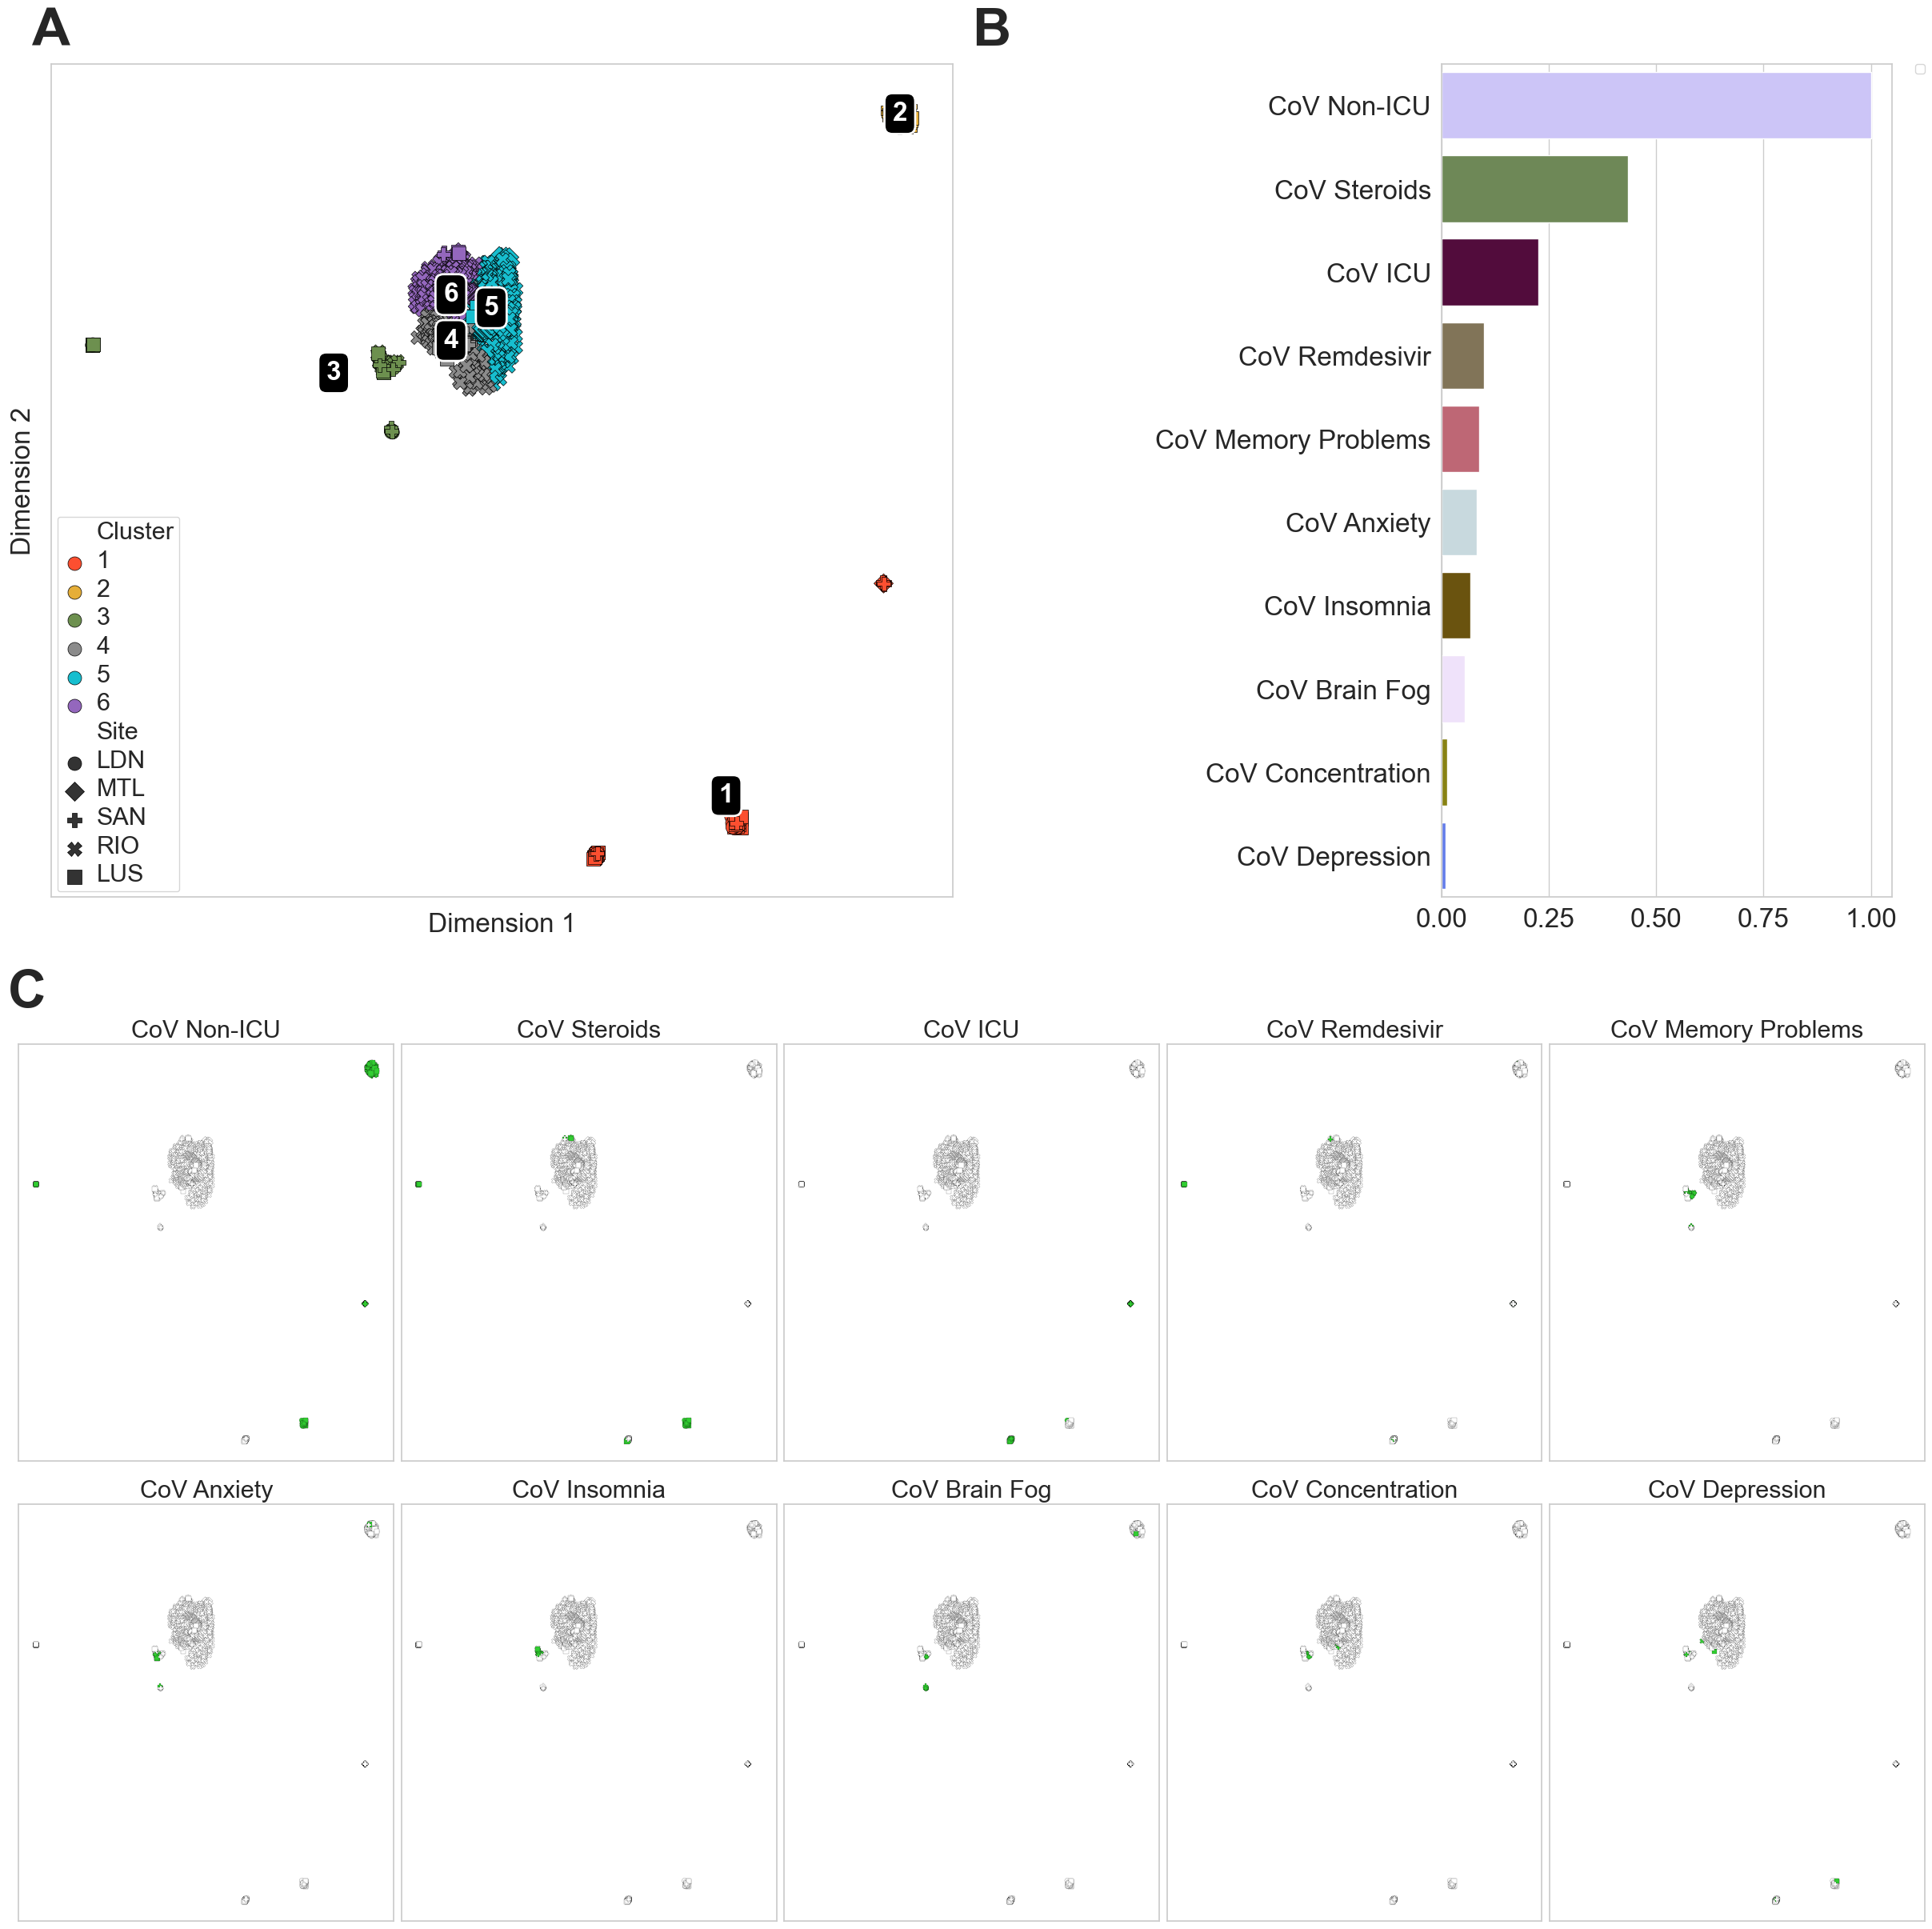

In [425]:
fig     = plt.figure(layout="constrained", figsize=(24,24))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[1,1], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, site_name_dict, title = None, centroids = True, size_by_prob = False, ax = axs0[0])
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# plot_clusters(plot_df, site_name_dict, title = None, centroids = True, size_by_prob = False, ax = axs0[1])

plot_feature_importances(features10, feature_map, feature_colour_map, axs0[1], FONTSIZE)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
axs1 = subfigs[1].subplots(2,5)

plot_multiple_features(fi_df[:10], 
                        X,
                        plot_df, 
                        feature_map, 
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        show_centroids = False,
                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

if SAVE:
    plt.savefig(f"{figdir}/new-worse-only-feature-importances.png", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances.jpg", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

In [426]:
X

CD-acute_kidney_injury___1  CD-acute_respiratory_distress___1  \
0                            0.0                                0.0   
1                            0.0                                0.0   
2                            0.0                                0.0   
3                            0.0                                0.0   
4                            0.0                                0.0   
...                          ...                                ...   
5659                         0.0                                0.0   
5660                         0.0                                0.0   
5661                         0.0                                0.0   
5662                         0.0                                0.0   
5663                         0.0                                0.0   

      CD-adjunctive___1  CD-anemia___1  CD-anxiety___1  CD-asthma___1  \
0                   0.0            0.0             0.0            0.0   
1                   0.0            0.0             0.0            0.0   
2                   0.0            0.0             0.0            0.0   
3                   0.0            0.0             0.0            0.0   
4                   0.0            0.0             0.0            0.0   
...                 ...            ...             ...            ...   
5659                0.0            0.0             0.0            0.0   
5660                0.0            0.0             0.0            0.0   
5661                0.0            0.0             0.0            0.0   
5662                0.0            0.0             0.0            0.0   
5663                0.0            0.0             0.0            0.0   

      CD-bacterial_viral_or_cryptog___1  CD-bacteriemia___1  CD-brain_fog___1  \
0                                   0.0                 0.0               0.0   
1                                   0.0                 0.0               0.0   
2                                   0.0                 0.0               0.0   
3                                   0.0                 0.0               0.0   
4                                   0.0                 0.0               0.0   
...                                 ...                 ...               ...   
5659                                0.0                 0.0               0.0   
5660                                0.0                 0.0               0.0   
5661                                0.0                 0.0               0.0   
5662                                0.0                 0.0               0.0   
5663                                0.0                 0.0               1.0   

      CD-bronchiolitis___1  ...  CD-pleural_effusion___2  CD-pneumothorax___2  \
0                      0.0  ...                      0.0                  0.0   
1                      0.0  ...                      0.0                  0.0   
2                      0.0  ...                      0.0                  0.0   
3                      0.0  ...                      0.0                  0.0   
4                      0.0  ...                      0.0                  0.0   
...                    ...  ...                      ...                  ...   
5659                   0.0  ...                      0.0                  0.0   
5660                   0.0  ...                      0.0                  0.0   
5661                   0.0  ...                      0.0                  0.0   
5662                   0.0  ...                      0.0                  0.0   
5663                   0.0  ...                      0.0                  0.0   

      CD-pulmonary_embolism_pe___2  CD-rhabdomyolysis___2  \
0                              0.0                    0.0   
1                              0.0                    0.0   
2                              0.0                    0.0   
3                              0.0                    0.0   
4                        

<Axes: >

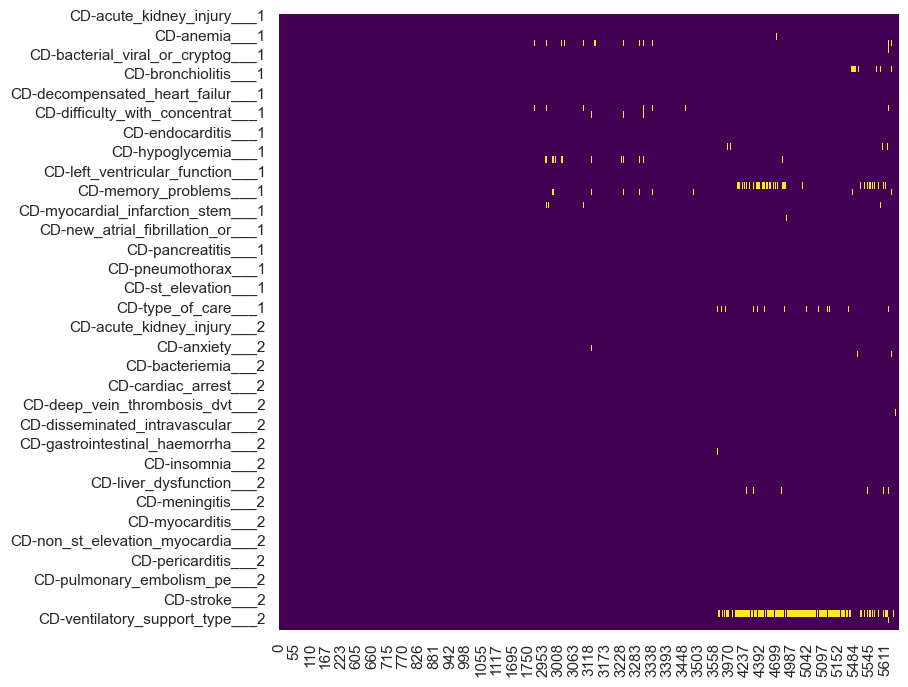

In [427]:
# heatmap of X
sns.heatmap(X.T, cmap = 'viridis', ax = None, cbar = False, square = False, linecolor = 'k', linewidth = 0)